In [229]:
import numpy as np
import netCDF4 as netcdf
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import Proj

# Helper Functions

In [230]:
def calculate_average(latitudes, longitudes, data, lat_bounds, lon_bounds, time_index):
    """
    Extracts a subset of data from latitudes, longitudes and calculates the average
    of chlorophyll_data over the specified region for a specific time index.

    Parameters:
        latitudes (ndarray): 1D array of latitude values.
        longitudes (ndarray): 1D array of longitude values.
        data (ndarray): 3D array of data (time, lat, lon).
        lat_bounds (tuple): Latitude bounds as (min_lat, max_lat).
        lon_bounds (tuple): Longitude bounds as (min_lon, max_lon).
        time_index (int): Time index to extract data for.

    Returns:
        float: Average chlorophyll concentration over the specified region.
    """
    # Extract the subset of data within the latitude and longitude bounds
    lat_min, lat_max = lat_bounds
    lon_min, lon_max = lon_bounds

    # Create a mask for the region of interest
    lat_mask = (latitudes >= lat_min) & (latitudes <= lat_max)
    lon_mask = (longitudes >= lon_min) & (longitudes <= lon_max)

    # Apply the mask to the chlorophyll data for the given time index
    region_data = data[time_index, :, :][np.ix_(lat_mask, lon_mask)]

    # Calculate and return the average, ignoring NaN values
    return np.nanmean(region_data)

# Dataset 1: Antarctic Chlorophyll

In [231]:
chlor_dataset = netcdf.Dataset("chlorophyll_2017_2022_antarctica.nc", "r")
#print file information
print(chlor_dataset)
print(chlor_dataset.variables['time'])

<class 'netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    _lastModified: 2022-06-18T05:03:50.000Z
    cdm_data_type: Grid
    Conventions: CF-1.6, COARDS, ACDD-1.3
    creator_email: data@oceancolor.gsfc.nasa.gov
    creator_name: NASA/GSFC/OBPG
    creator_type: group
    creator_url: https://oceandata.sci.gsfc.nasa.gov
    date_created: 2022-06-18T05:03:50.000Z
    Easternmost_Easting: 179.97917
    geospatial_lat_max: -60.97917
    geospatial_lat_min: -89.97917
    geospatial_lat_resolution: 0.04166666589488307
    geospatial_lat_units: degrees_north
    geospatial_lon_max: 179.97917
    geospatial_lon_min: -179.97917
    geospatial_lon_resolution: 0.041666674383609215
    geospatial_lon_units: degrees_east
    history: Files downloaded daily from https://oceandata.sci.gsfc.nasa.gov/MODIS-Aqua/L3SMI to NOAA SWFSC ERD (erd.data@noaa.gov)
ERDDAP adds the time dimension.
Direct read of HDF4 file through CDM library
2025-04-29T11:47:47Z (local files)
20

In [232]:
# Extract latitude and longitude values
latitudes = np.array(chlor_dataset.variables['latitude'][:])
longitudes = np.array(chlor_dataset.variables['longitude'][:])

# Extract the time variable and convert it to dates
time_variable = chlor_dataset.variables['time'][:]  # Time in seconds since 1970-01-01
reference_date = datetime(1970, 1, 1)  # Unix epoch
chlor_dates = [reference_date + timedelta(seconds=int(seconds)) for seconds in time_variable]

# Define the variable of interest
chlorophyll_data = np.array(chlor_dataset.variables['chlorophyll'][:])  # Extract the data for the variable

# Dataset 2: Antarctic Sea Ice Concentration

## Load Dataset

In [233]:
seaice_dataset = netcdf.Dataset("seaice_concentration_2003_2024_antarctica.nc", "r")
#print file information
print(seaice_dataset)
print(seaice_dataset.variables)

<class 'netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    acknowledgement: This project was supported in part by a grant from the NOAA Climate Data Record Program. Production of original NASA Team and Bootstrap algorithm estimates supported by the NASA Polar Distributed Active Archive Center. The sea ice concentration algorithms were developed by Donald J. Cavalieri, Josefino C. Comiso, Claire L. Parkinson, and others at the NASA Goddard Space Flight Center in Greenbelt, MD.
    cdm_data_type: Grid
    cdr_variable: cdr_seaice_conc_monthly
    contributor_name: Walter N. Meier, Florence Fetterer, Ann Windnagel, J. Scott Stewart, Trey Stafford, Matt Fisher
    contributor_role: principal investigator, author, author, software developer, software developer, software developer
    Conventions: CF-1.6, ACDD-1.3, COARDS
    creator_email: nsidc@nsidc.org
    creator_name: NSIDC
    creator_type: institution
    creator_url: https://nsidc.org/
    date_creat

## Preprocess Data

In [234]:
# Extract time variable and convert it to dates
time_variable = seaice_dataset.variables['time'][:]  # Time in seconds since 1970-01-01
reference_date = datetime(1970, 1, 1)  # Unix epoch
seaice_dates = [reference_date + timedelta(seconds=int(seconds)) for seconds in time_variable]



In [235]:
# Define the polar stereographic projection
proj_polar = Proj(proj="stere", lat_0=-90, lat_ts=-70, lon_0=0, x_0=0, y_0=0, a=6378273, b=6356889.449, units="m")

# Extract x and y grid coordinates (in meters)
x = seaice_dataset.variables['xgrid'][:]  # Replace with the correct variable name
y = seaice_dataset.variables['ygrid'][:]

# Create a meshgrid of x and y
seaice_x_grid, seaice_y_grid = np.meshgrid(x, y)

# Convert x, y to longitude and latitude
seaice_lon_grid, seaice_lat_grid = proj_polar(seaice_x_grid, seaice_y_grid, inverse=True)

## Plot Monthly Maps

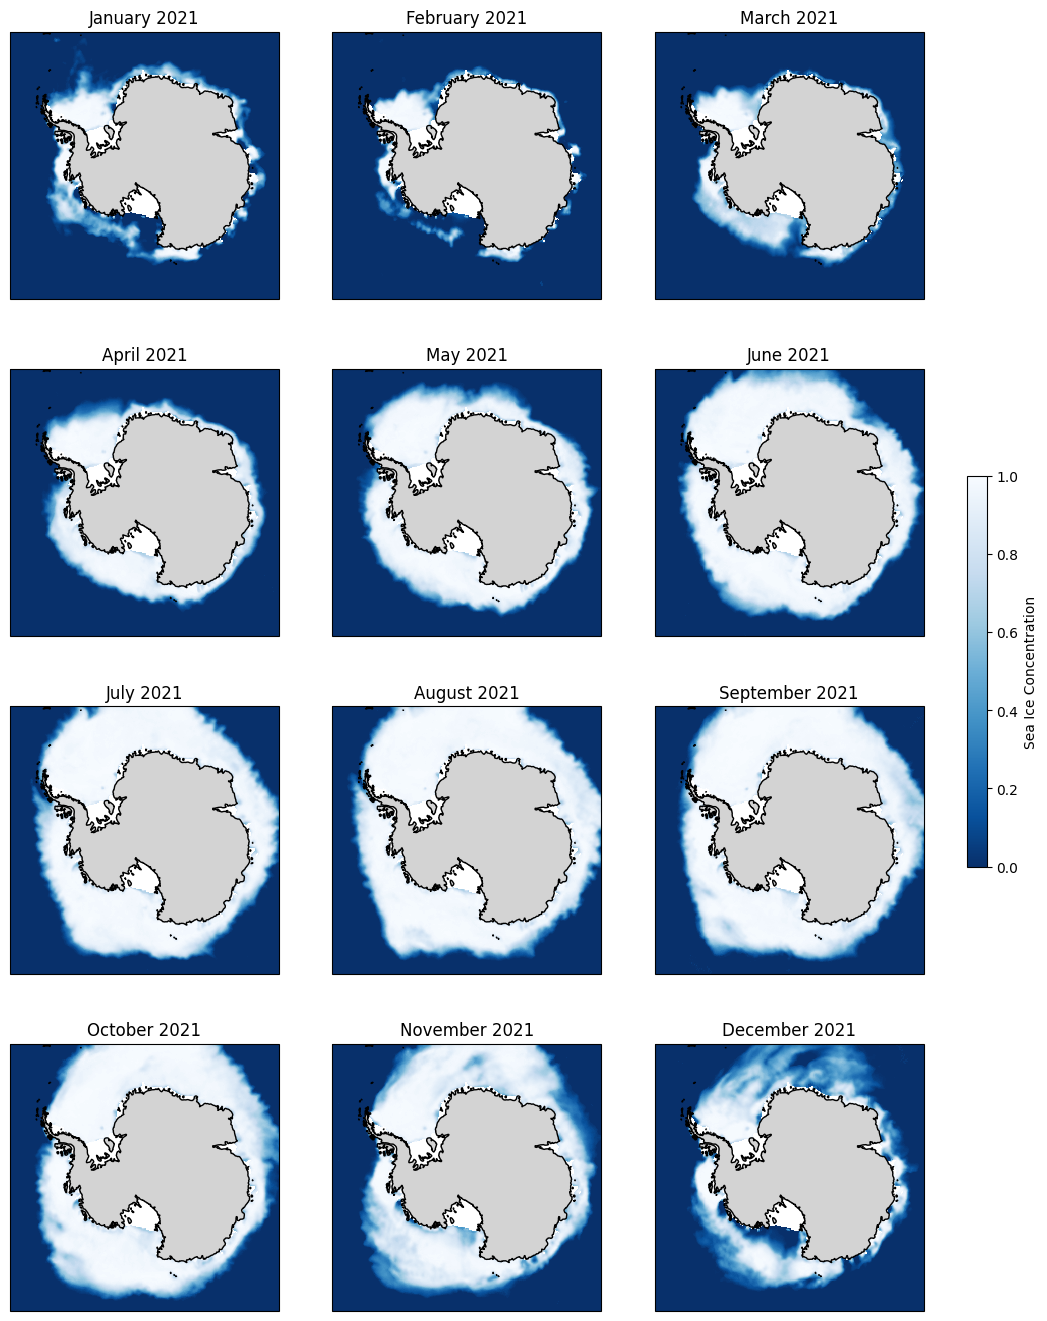

In [278]:
sea_ice_concentration = seaice_dataset.variables['cdr_seaice_conc_monthly']
# Create a figure with 12 subplots (2 columns, 6 rows)
fig, axes = plt.subplots(4, 3, figsize=(4.2*3, 4.2*4), subplot_kw={'projection': ccrs.SouthPolarStereo()})
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

# Plot each time index
ref=216 #change this number to change the starting month
for i in range(12):
    ax = axes[i]
    ax.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_feature(cfeature.COASTLINE)

    # Plot the heatmap for the current time index
    mesh = ax.pcolormesh(seaice_lon_grid, seaice_lat_grid, sea_ice_concentration[i+ref, :, :], transform=ccrs.PlateCarree(), cmap='Blues_r', shading='auto')

    # Add a title for each subplot with month and year
    date = seaice_dates[i+ref]
    ax.set_title(f"{date.strftime('%B %Y')}")

# Add a colorbar for the entire figure
cbar = fig.colorbar(mesh, ax=axes, orientation='vertical', fraction=0.02, pad=0.1)
cbar.set_label('Sea Ice Concentration')

# Adjust layout
plt.subplots_adjust(right=0.85)
#plt.tight_layout()

# Show the plot
plt.show()

## Compute Average Sea Ice Concentration for a Given Region

In [237]:
def calculate_average_sea_ice(lat_grid, lon_grid, sea_ice_concentration, lat_bounds, lon_bounds, time_index):
    """
    Extracts a subset of data from lat_grid, lon_grid and calculates the average
    of sea_ice_concentration over the specified region for a specific time index.

    Parameters:
        lat_grid (ndarray): 2D array of latitude values.
        lon_grid (ndarray): 2D array of longitude values.
        sea_ice_concentration (ndarray): 3D array of sea ice concentration (time, lat, lon).
        lat_bounds (tuple): Latitude bounds as (min_lat, max_lat).
        lon_bounds (tuple): Longitude bounds as (min_lon, max_lon).
        time_index (int): Time index to extract data for.

    Returns:
        float: Average sea ice concentration over the specified region.
    """
    # Extract the subset of data within the latitude and longitude bounds
    lat_min, lat_max = lat_bounds
    lon_min, lon_max = lon_bounds

    # Create a mask for the region of interest
    region_mask = (
        (lat_grid >= lat_min) & (lat_grid <= lat_max) &
        (lon_grid >= lon_min) & (lon_grid <= lon_max)
    )

    # Apply the mask to the sea ice concentration data for the given time index
    region_data = sea_ice_concentration[time_index, :, :][region_mask]

    # Calculate and return the average, ignoring NaN values
    return np.nanmean(region_data)

# SST

In [238]:
sst_dataset = netcdf.Dataset("sst_2003_2022_monthly_antarctica.nc", "r")
#print file information
print(sst_dataset)
print(sst_dataset.variables)

<class 'netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    cdm_data_type: Grid
    Conventions: CF-1.6, COARDS, ACDD-1.3
    creation_date: 2025-05-03
    creator_email: erd.data@noaa.gov
    creator_name: NOAA NMFS SWFSC ERD and NOAA NESDIS CoastWatch WCRN
    creator_type: institution
    creator_url: https://www.pfeg.noaa.gov
    Easternmost_Easting: 179.01
    geospatial_lat_max: -60.99
    geospatial_lat_min: -89.99
    geospatial_lat_resolution: 0.01
    geospatial_lat_units: degrees_north
    geospatial_lon_max: 179.01
    geospatial_lon_min: -179.99
    geospatial_lon_resolution: 0.01
    geospatial_lon_units: degrees_east
    history: This monthly-composite, source foundation, SST data is created by ERD Data (erd.data@noaa.gov) from daily data from ftp://podaac-ftp.jpl.nasa.gov/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR.
2025-05-06T10:49:26Z (local files)
2025-05-06T10:49:26Z https://coastwatch.pfeg.noaa.gov/erddap/griddap/jplMURSST41mday.nc?sst%

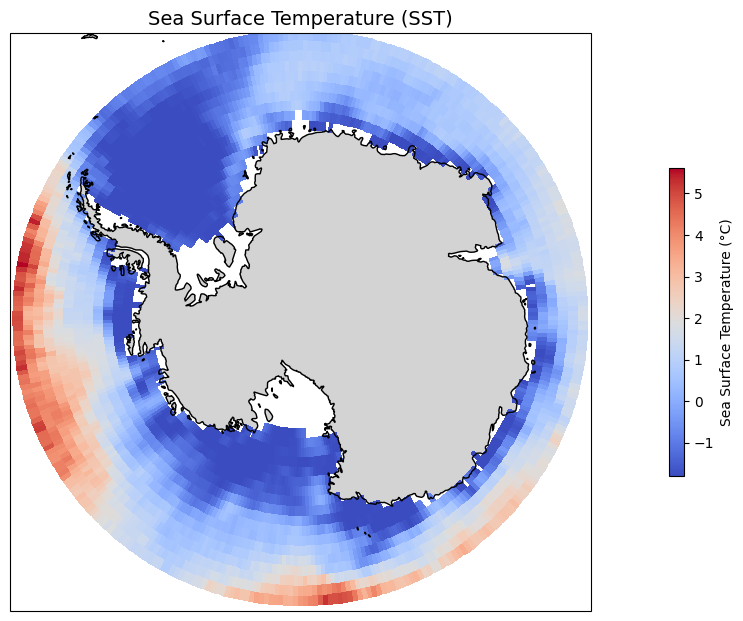

In [239]:
sst_data = sst_dataset.variables['sst'][0, :, :]  # Replace 0 with the desired time index
lon = sst_dataset.variables['longitude'][:]
lat = sst_dataset.variables['latitude'][:]

# Create a meshgrid for longitude and latitude
lon_grid, lat_grid = np.meshgrid(lon, lat)

# Create the polar stereographic map
fig, ax = plt.subplots(
    figsize=(10, 8),
    subplot_kw={'projection': ccrs.SouthPolarStereo()}
)

# Set the extent to focus on the Antarctic region
ax.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())

# Add features to the map
ax.add_feature(cfeature.LAND, color='lightgray')
ax.add_feature(cfeature.COASTLINE)

# Plot the SST data
sst_plot = ax.pcolormesh(
    lon_grid, lat_grid, sst_data,
    transform=ccrs.PlateCarree(),
    cmap='coolwarm', shading='auto'
)

# Add a colorbar
cbar = plt.colorbar(sst_plot, ax=ax, orientation='vertical', shrink=0.5, pad=0.1)
cbar.set_label('Sea Surface Temperature (°C)')

# Add a title
ax.set_title('Sea Surface Temperature (SST)', fontsize=14)

# Show the plot
plt.show()

In [240]:
print(sst_dataset.variables['sst']._FillValue)  # Check the fill value

-999.0


# Comparison

## Choose Bloom Site and Load Chlorophyll Data

In [269]:
site = "3"

In [270]:
if site == "1":
    lat_bounds = (-78.12, -74.11)  
    lon_bounds = (161.24, 179.85)
    bloom_dataset = netcdf.Dataset("chlorophyll_2003_2022_weekly_siteA.nc", "r")
    sst_dataset = netcdf.Dataset("sst_2003_2022_monthly_siteA.nc", "r")
elif site == "2":
    lat_bounds = (-65.32, -62.08)  
    lon_bounds = (-58.2, -43.97)  
    bloom_dataset = netcdf.Dataset("chlorophyll_2003_2022_weekly_siteB.nc", "r")
    sst_dataset = netcdf.Dataset("sst_2003_2022_monthly_siteB.nc", "r")
elif site == "3":
    lat_bounds = (-70.42, -67.18)  
    lon_bounds = (14.526, 28.82)
    bloom_dataset = netcdf.Dataset("chlorophyll_2003_2022_weekly_siteC.nc", "r")
    sst_dataset = netcdf.Dataset("sst_2010_2022_monthly_siteC.nc", "r")

# Extract latitude and longitude values
bloom_latitudes = np.array(bloom_dataset.variables['latitude'][:])
bloom_longitudes = np.array(bloom_dataset.variables['longitude'][:])

sst_latitudes = np.array(sst_dataset.variables['latitude'][:])
sst_longitudes = np.array(sst_dataset.variables['longitude'][:])

# Extract the time variable and convert it to dates
reference_date = datetime(1970, 1, 1)  # Unix epoch
bloom_time_variable = bloom_dataset.variables['time'][:]  # Time in seconds since 1970-01-01
bloom_dates = [reference_date + timedelta(seconds=int(seconds)) for seconds in bloom_time_variable]

sst_time_variable = sst_dataset.variables['time'][:]  # Time in seconds since 1970-01-01
sst_dates = [reference_date + timedelta(seconds=int(seconds)) for seconds in sst_time_variable]

# Define the variable of interest
bloom_data = np.array(bloom_dataset.variables['chlorophyll'][:])  # Extract the data for the variable
# IMPORTANT: mask -999 fill value to NAN for SST data
sst_data = np.array(sst_dataset.variables['sst'][:])  # Extract the data for the variable
fill_value = sst_dataset.variables['sst']._FillValue
sst_data = np.where(sst_data == fill_value, np.nan, sst_data) 

In [271]:
calculate_average(sst_latitudes, sst_longitudes, sst_data, lat_bounds, lon_bounds, 0)

-1.7998564

## Define Time Range

In [272]:
print(len(bloom_dataset.variables['time']))
print(len(seaice_dataset.variables['time']))
print(bloom_dates[0])
print(seaice_dates[172])
print(seaice_dates[230])



890
264
2003-01-05 00:00:00
2017-05-01 00:00:00
2022-03-01 00:00:00


In [273]:
# Create the time series plot with two y-axes
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add the first time series (primary y-axis)
fig.add_trace(
    go.Scatter(
        x=bloom_dates,
        y=[calculate_average(bloom_latitudes, bloom_longitudes, bloom_data, lat_bounds, lon_bounds, t) for t in range(len(bloom_dates))],
        mode='lines+markers',
        name='Chlorophyll [mg/m3]',
    ),
    secondary_y=False  # Use the primary y-axis
)

# Add the second time series (secondary y-axis)
fig.add_trace(
    go.Scatter(
        x=seaice_dates[:231],
        y= [calculate_average_sea_ice(seaice_lat_grid, seaice_lon_grid, sea_ice_concentration, lat_bounds, lon_bounds, t) for t in range(len(seaice_dates[:231]))],
        mode='lines+markers',
        name='Sea Ice Concentration'
    ),
    secondary_y=True  # Use the secondary y-axis
)

# Update layout for better visualization
fig.update_layout(
    title=f"Time Series of Chlorophyll and Sea Ice Concentration for Area {site}",
    xaxis_title="Time",
    yaxis_title="Chlorophyll [mg/m3]",  # Label for the primary y-axis
    yaxis2_title= "Sea Ice Concentration",  # Label for the secondary y-axis
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True),
    yaxis2=dict(showgrid=False)  # Optional: Disable grid for secondary y-axis
)

# Show the plot
fig.show()

/var/folders/_n/j6tbgncd4nl_y_25l1f3fqvw0000gn/T/ipykernel_83006/1503369607.py:29: RuntimeWarning:

Mean of empty slice



/var/folders/_n/j6tbgncd4nl_y_25l1f3fqvw0000gn/T/ipykernel_83006/1503369607.py:29: RuntimeWarning:

Mean of empty slice



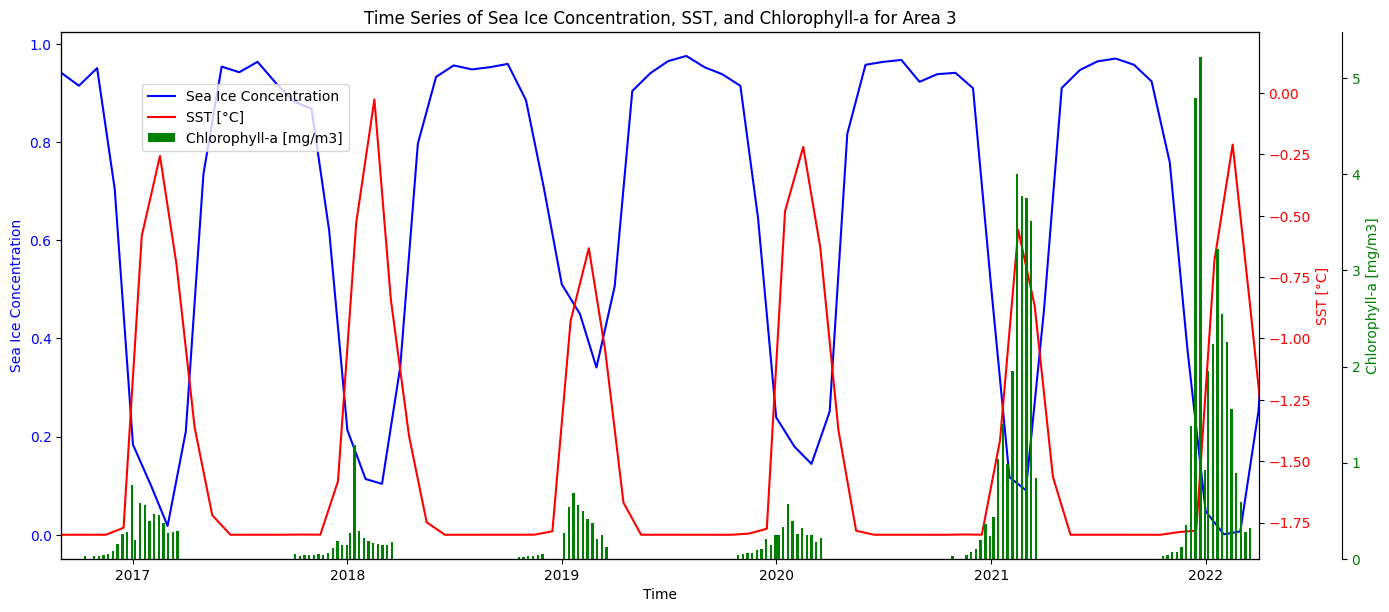

In [274]:
# Create the base figure and axis
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot the first trace
ax1.plot(seaice_dates,
        [calculate_average_sea_ice(seaice_lat_grid, seaice_lon_grid, sea_ice_concentration, lat_bounds, lon_bounds, t) for t in range(len(seaice_dates))],
          'b-', label='Sea Ice Concentration')
ax1.set_xlabel('Time')
ax1.set_ylabel('Sea Ice Concentration', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xlim(datetime(2016, 9, 1), datetime(2022, 4, 1))  # Example date range

# Create a second y-axis for the second trace
ax2 = ax1.twinx()
ax2.plot(sst_dates, 
         [calculate_average(sst_latitudes, sst_longitudes, sst_data, lat_bounds, lon_bounds, t) for t in range(len(sst_dates))], 
          'r-', label='SST [°C]')
ax2.set_ylabel('SST [°C]', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Create a third y-axis for the third trace
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis
ax3.bar(
    bloom_dates, 
    [calculate_average(bloom_latitudes, bloom_longitudes, bloom_data, lat_bounds, lon_bounds, t) for t in range(len(bloom_dates))], 
    color='g', 
    label='Chlorophyll-a [mg/m3]', 
    width=4
)
ax3.set_ylabel('Chlorophyll-a [mg/m3]', color='g')
ax3.tick_params(axis='y', labelcolor='g')

# Add a legend
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Adjust layout
fig.tight_layout()
plt.title('Time Series of Sea Ice Concentration, SST, and Chlorophyll-a for Area ' + site)
# Show the plot
plt.show()

In [247]:
print(bloom_latitudes.min(), bloom_latitudes.max())
print(bloom_longitudes.min(), bloom_longitudes.max())
print(lat_bounds_3, lon_bounds_3)
print(bloom_data[1])
print([calculate_average(bloom_latitudes, bloom_longitudes, bloom_data, lat_bounds, lon_bounds, t) for t in range(len(bloom_dates))])

-78.10417 -74.10417
161.22917 179.85417
(-70.42, -67.18) (14.526, 28.82)
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/var/folders/_n/j6tbgncd4nl_y_25l1f3fqvw0000gn/T/ipykernel_83006/1503369607.py:29: RuntimeWarning:

Mean of empty slice



[0.64736044, 0.61411494, 0.5326793, 0.3820476, 0.47186926, 0.4336911, 0.5530814, 0.14508685, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.050339036, 0.07442238, 0.105013095, 0.21817613, 2.9304457, 3.6013565, 1.6386657, 1.1595631, 0.6467262, 0.7213552, 1.0978522, 1.805575, 2.2347505, 2.2019765, 2.513992, 0.9258439, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.102078, 0.18565392, 0.98941934, 2.7065902, 1.5648735, 1.6453, 2.4689047, 2.4840763, 2.0938437, 0.59524035, 0.60413194, 0.37461734, 0.32275814, 0.40842924, 0.24484394, 0.3080207, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.04878327, 0.062457114, 0.11250923, 0.083317146, 4.1905985, 2.6406984, 3.1613877, 3.2911334, 2.172439

In [248]:
lat_mask = (bloom_latitudes >= lat_bounds_3[0]) & (bloom_latitudes <= lat_bounds_3[1])
lon_mask = (bloom_longitudes >= lon_bounds_3[0]) & (bloom_longitudes <= lon_bounds_3[1])
region_data = bloom_data[0, :, :][np.ix_(lat_mask, lon_mask)]
print(region_data)
fill_value = bloom_dataset.variables['chlorophyll']._FillValue
print(fill_value)
print(len(bloom_data))

[]
nan
890
